<a href="https://colab.research.google.com/github/M-torki/CSNN/blob/master/CMB_Stage4_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/My\ Drive/

/gdrive/My Drive


In [ ]:
!pip install git+https://github.com/vafaei-ar/ccgpack.git

  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-rqj9u_xn
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-rqj9u_xn
  Created wheel for ccgpack: filename=ccgpack-0.1.0-cp36-cp36m-linux_x86_64.whl size=907248 sha256=f62fc348a7895dc3c90ba3c08aaf110db6fb17129572c7828dc171d359aa0737
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8zixb7m/wheels/a8/3c/86/3720d002b7c606972520b7468f7b9daf3da3acc3052facac45
Successfully built ccgpack


In [ ]:
!pip install git+https://github.com/vafaei-ar/Ngene.git

  Cloning https://github.com/vafaei-ar/Ngene.git to /tmp/pip-req-build-yucph4mm
  Running command git clone -q https://github.com/vafaei-ar/Ngene.git /tmp/pip-req-build-yucph4mm
  Created wheel for ngene: filename=ngene-0.1.0-cp36-none-any.whl size=11660 sha256=6a57105d032a327deafade7457a887fdeb88711f535ad9e952ca34f2515ddf3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tu5v3lqa/wheels/f7/d2/a8/1dae975d187b4a9790d83da45caaef0d018b41ffc0ab7fceb7
Successfully built ngene


In [ ]:
import os
import ngene as ng
import numpy as np
import pylab as plt
from glob import glob
import tensorflow as tf
from random import choice,shuffle
from sklearn.metrics import accuracy_score
import cv2 as cv

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
!nvidia-smi

Thu Aug 20 19:34:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12152473670787698458, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2303034746563183719
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14616043418730031615
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17367996956971902000
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import sys
sys.path.append('/gdrive/My\ Drive/git_reps/ccgpack')
sys.path.append('/gdrive/My\ Drive/git_reps/Ngene')

In [ ]:
def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):

    if not title:
        if mode == 'train':
            title = 'Normalized confusion matrix on train dataset'
        if mode == 'test':
            title = 'Normalized confusion matrix on test dataset'
        if mode == 'prob':
            title = 'Normalized confusion matrix on Non-Overlapping test dataset'
            

    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel= 'True label',
           xlabel='Predicted label')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                    
        item.set_fontsize(15)
     
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        
        item.set_fontsize(12)

                
    plt.gca().invert_yaxis()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save == 1:
        plt.savefig(name)
    return ax

In [ ]:
g_files = sorted(glob('./data/Healpix_p/*.npy'))
s_files = sorted(glob('./data/string_p/*.npy'))

if len(g_files)*len(s_files)==0:
    print('Somthing is wrong with initiation.')
    #exit()

print(len(g_files),len(s_files))

409 12


In [ ]:
# for i in range(200,205):
#     print(np.std(np.load('./data/Healpix_p/'+str(i)+'.npy')))

In [ ]:
np.std(np.load('./data/string_p/0.npy'))

15.552519

In [ ]:
np.std(np.load('./data/Healpix_p/0.npy'))

0.00010903541

In [ ]:
def get_slice(data,nx,ny):
    """Slice matrix in x and y direction"""
    lx,ly = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    return slx, sly


class OrganizedDataProvider(object):
    def __init__(self,n_files,s_files,gmus,
                 s2n, 
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None ,test=0 , noisy=1):

        self.n_files = n_files
        self.s_files = s_files
        self.test = test
        self.s2n = s2n
        self.noisy = noisy

        nmin = min(len(n_files),len(s_files))
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        self.gmus = gmus
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()
            
    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
        self.s_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))
        
        if self.test:
            sind = (nind%12)
        else:

            sind = np.random.randint(1,3)
            if sind==1:
                sind = (nind%12)
            elif sind==2:
                sind = (nind%12)+12
            
#         print('sind' , sind , 'nind' , nind)



    #        ninds = np.arange(len(self.n_files))
    #        sinds = np.arange(len(self.s_files))
    #        shuffle(ninds)
    #        shuffle(sinds)
        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            files = self.s_files[sind]
            self.n_set.append(np.load(filen))
            signal = np.load(files)
            self.s_set.append(signal)
    #            if self.filt:
    #                self.d_set.append(self.filt(signal))
    #            else:
    #                self.d_set.append(signal)
    #            

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        s = self.s_set[ind]
        n = self.n_set[ind]
#         print('ind' , ind)


    #        d = self.d_set[sind]
        return n,s#,d


    def pre_process(self, n, s, gmu):
        
        sn = n + gmu*s
        snslice = get_slice(sn,self.nx,self.ny)
        sn = sn[snslice]
            #    sslice = get_slice(s,self.nx,self.ny)
            #    s = s[sslice]

        if self.noisy == 1:
            noise = np.random.normal(0, 0.000109704/self.s2n ,sn.shape)
            sn = sn +noise

        # sn = self.filt(sn)
        #        d = d[sslice]
        #        d = np.expand_dims(d,-1)
        return sn #, (n*1e-6).std()#,d

    def __call__(self, n, gmus=None): 

        if gmus is None:
            gmus = self.gmus
        n_class = len(gmus)
        #        x,y = self.get_data()
        X = []
        Y = []
        for i in range(n):                
            n,s = self.get_data()
            # print(n.shape)
            inds = np.arange(n_class)
            shuffle(inds)
            gmu = gmus[inds[0]]
            #            gmu = choice(gmus)
            sn  = self.pre_process(n,s,gmu)
            # print(np.std(sn))
            sn = np.float32(sn)
            sn = cv.bilateralFilter(sn,3,1e-3,1e-3)
            # sn = (sn - np.min(sn))/(np.max(sn) - np.min(sn))
            sn = (sn - np.mean(sn))/(np.std(sn) + 1e-30)
            sn = np.expand_dims(sn,-1)

            X.append(sn)
            #            Y.append(-np.log10(gmu+1e-30))
            lbl = n_class*[0]
            lbl[inds[0]] = 1
            Y.append(lbl)

        X = np.array(X)
        Y = np.array(Y)

        return X,Y

In [ ]:
dofilt = 'y'

if dofilt[0]=='y':
    import ccgpack as ccg
    def filt(x):
        return ccg.filters(x,edd_method='sch')
else:
    filt = None

In [ ]:
gmus = [0]+list(5* 10**np.linspace(-8 , -5 , 10))
n_class = len(gmus)
print(gmus)

gmus2 = [gmus[i]*0.17760559 for i in range(n_class)]
print(gmus ,'\n', gmus2)

[0, 5e-08, 1.0772173450159411e-07, 2.320794416806391e-07, 5e-07, 1.0772173450159411e-06, 2.3207944168063863e-06, 4.9999999999999996e-06, 1.0772173450159412e-05, 2.3207944168063865e-05, 5e-05]
[0, 5e-08, 1.0772173450159411e-07, 2.320794416806391e-07, 5e-07, 1.0772173450159411e-06, 2.3207944168063863e-06, 4.9999999999999996e-06, 1.0772173450159412e-05, 2.3207944168063865e-05, 5e-05] 
 [0.0, 8.8802795e-09, 1.9131982211978978e-08, 4.12186061665605e-08, 8.8802795e-08, 1.913198221197898e-07, 4.121860616656042e-07, 8.8802795e-07, 1.9131982211978978e-06, 4.121860616656042e-06, 8.880279500000001e-06]


In [ ]:
labels = []
for gmu in gmus2:
    labels.append('{:3.1e}'.format(gmu))

In [ ]:
odp = OrganizedDataProvider(g_files,s_files,
                              gmus=gmus,
                              s2n = 20., 
                              nx=256,ny=256,n_buffer=10,
                              reload_rate=1e5,filt=filt,test=1 , noisy=1)

Data provider is reloading...


In [ ]:
x , y = odp(1)
np.argmax(y)

5

In [ ]:
# c=0 

# for i in range(120):
#     c+= np.std(np.load('./data/Healpix_p/'+str(i)+'.npy'))
# print(c/120)

In [ ]:
np.std(np.load('./data/string_p/0.npy'))

15.552519

In [ ]:
x , y = odp(1)

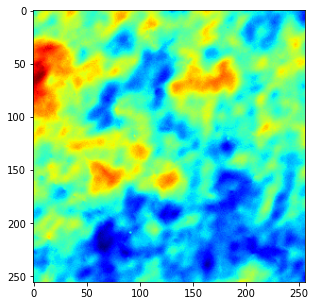

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(odp(1)[0][0,:,:,0] , cmap='jet')

In [ ]:
g_test = sorted(glob('./data/test/healpix_p/*.npy'))
# s_test = sorted(glob('./data/test/string_p/*.npy'))

if len(g_test)*len(s_files)==0:
    print('Somthing is wrong with initiation.')
#     exit()
print(len(g_test) , len(s_files))

60 12


In [ ]:
odp_test = OrganizedDataProvider(g_test,s_files,
                                 gmus=gmus,
                                 s2n = 20. ,
                                 nx=256,ny=256,n_buffer=10,
                                 reload_rate=1e5,filt=filt,test=1 , noisy=1)

Data provider is reloading...


In [ ]:
def arch_maker(x,n_conv,n_class):

    print("\033[91m ============================= Begin ========================= \033[0m")
    
    for _ in range(4):

        x = tf.layers.conv2d(x,filters=8,kernel_size=5,
                              strides=(1, 1),padding='same' , trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)

    for _ in range(n_conv-2):

        x = tf.layers.conv2d(x,filters=8,kernel_size=5,
                              strides=(2, 2),padding='same', trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)

        x = tf.layers.conv2d(x,filters=16,kernel_size=5,
                              strides=(1, 1),padding='same', trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)
        
    for _ in range(2):

        x = tf.layers.conv2d(x,filters=8,kernel_size=5,
                              strides=(2, 2),padding='same', trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)

        x = tf.layers.conv2d(x,filters=16,kernel_size=5,
                              strides=(1, 1),padding='same', trainable=1)
        print(x)
        x = tf.layers.batch_normalization(x, trainable=1)
        print(x)
        x = tf.nn.crelu(x)
        print(x)
        x = tf.layers.max_pooling2d(x,pool_size=2,strides=1)
        print(x)

    x = tf.contrib.layers.flatten(x)
    print(x)
    x = tf.layers.dense(x, 40 , activation=tf.nn.crelu)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    x = tf.layers.dense(x, 20 , activation=tf.nn.crelu)
    print(x)
    x = tf.nn.dropout( x, keep_prob=0.5)
    print(x)
    y = tf.layers.dense(x, n_class, activation=tf.nn.softmax)
    print(y)

    print("\033[91m ============================ END ============================= \033[0m")

    return y

In [ ]:
restore = os.path.isdir('./models/s4ii')
restore = 1

In [ ]:
def arch(x):
    return arch_maker(x,6,n_class)    

In [ ]:
def loss(y_true,x_out):
    return tf.losses.huber_loss(y_true,x_out)  

In [ ]:
conv = ng.Model(data_provider= odp,
                 optimizer=tf.train.AdamOptimizer,
                 loss = loss,
                 restore=restore,
                 model_add= './models/Bilatnoise_s4ii2',
                 arch=arch)

 ============================= Begin ========================= 
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Tensor("conv2d/BiasAdd:0", shape=(?, 256, 256, 8), dtype=float32)
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Tensor("batch_normalization/FusedBatchNormV3:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("CRelu/Relu:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("conv2d_1/BiasAdd:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("batch_normalization_1/FusedBatchNormV3:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("CRelu_1/Relu:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 256, 256, 8), dtype=float32)
Tensor("batch_normalization_2/FusedBatchNormV3:0", shape=(?, 256, 2

#Correction of labels :

In [ ]:
gmus3 = [gmus[i]/2.7 for i in range(n_class)]
print('\n', gmus3)   
labels = []
for gmu in gmus3:
    labels.append('{:3.1e}'.format(gmu)) 

class Cheater(object):
    def __init__(self,n_files,s_files,gmus,s2n,gstd=None,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None , test=0 , noisy=1):

        self.n_files = n_files
        self.s_files = s_files
        self.test = test
        self.noisy = noisy
        self.s2n = s2n
        self.gstd = gstd



        nmin = min(len(n_files),len(s_files))
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        self.gmus = gmus
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()

    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
        self.s_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))
        
        if self.test:
            sind = (nind%12)
        else:

            sind = np.random.randint(1,3)
            if sind==1:
                sind = (nind%12)
            elif sind==2:
                sind = (nind%12)+12
            
#         print('sind' , sind , 'nind' , nind)



    #        ninds = np.arange(len(self.n_files))
    #        sinds = np.arange(len(self.s_files))
    #        shuffle(ninds)
    #        shuffle(sinds)
        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            files = self.s_files[sind]
            self.n_set.append(np.load(filen))
            signal = np.load(files)
            self.s_set.append(signal)
    #            if self.filt:
    #                self.d_set.append(self.filt(signal))
    #            else:
    #                self.d_set.append(signal)
    #            

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        s = self.s_set[ind]
        n = self.n_set[ind]
#         print('ind' , ind)


    #        d = self.d_set[sind]
        return n,s#,d


    def pre_process(self, n, s, gmu):
        
        sn = []
        
        for _ in range(30):
            
            sn1 = n + gmu*(s)
            # sn = gmu*(s)

            snslice = get_slice(sn1,self.nx,self.ny)
            sn1 = sn1[snslice]
            if self.noisy == 1:
                noise = np.random.normal(0, 0.000109704/self.s2n ,sn1.shape)
                sn1 = sn1 +noise
            sn1 = np.float32(sn1)
            sn1 = cv.bilateralFilter(sn1,3,1e-3,1e-3)
            # sn1 = self.filt(sn1)
            sn1 = (sn1 - np.mean(sn1))/(np.std(sn1) + 1e-30)


            sn.append(sn1)
            

        #        sslice = get_slice(s,self.nx,self.ny)
        #        s = s[sslice]

        #        d = d[sslice]
        sn = np.expand_dims(sn,-1)
        #        d = np.expand_dims(d,-1)
        return sn#,d

    def __call__(self, n, gmus=None): 

        if gmus is None:
            gmus = self.gmus
        n_class = len(gmus)
        #        x,y = self.get_data()
        X = []
        Y = []
        for i in range(n):                
            n,s = self.get_data()
            # print(n.shape)
            inds = np.arange(n_class)
            shuffle(inds)
            gmu = gmus[inds[0]]
            #            gmu = choice(gmus)
            sn  = self.pre_process(n,s,gmu)
            #            rand = np.random.randint(0,2)
            #            sn = sn-sn+rand

#             sn = (sn - np.min(sn))/(np.max(sn) - np.min(sn))

            #            Y.append(-np.log10(gmu+1e-30))

            lbl = n_class*[0]
            lbl[inds[0]] = 1
            Y.append(lbl)
            X.append(sn)


        X = np.array(X)
        Y = np.array(Y)

        return X,Y


 [0.0, 1.8518518518518515e-08, 3.9896938704294115e-08, 8.595534877060707e-08, 1.8518518518518516e-07, 3.989693870429411e-07, 8.595534877060689e-07, 1.8518518518518517e-06, 3.989693870429411e-06, 8.59553487706069e-06, 1.8518518518518518e-05]


In [ ]:
ch_test = Cheater(g_test,s_files,
                    gmus=gmus,
                    s2n = 20,
                    nx=256,ny=256,n_buffer=10,
                    reload_rate=1e5,filt=filt,test=1 , noisy=1)

Data provider is reloading...


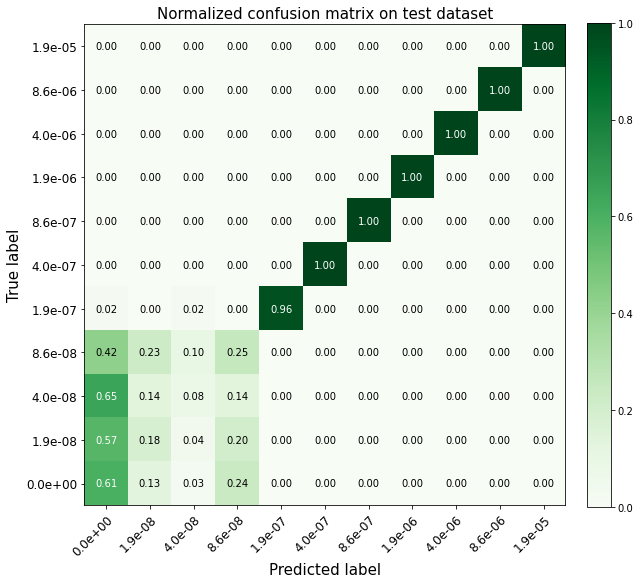

In [ ]:
Y_t  = [] 
pr_t = []

for _ in range(500):
    
    x, y = ch_test(1)
    pred = []
    for i in range(30):
        
        pred.append(conv.predict(x[:,i,:,:,:]))
#     print(np.array(pred).shape)    
    preds = np.prod(np.vstack(pred), axis=0)
    preds = preds/(sum(preds))
#     print(preds)    

        
    Y_t.append(np.argmax(y))
    pr_t.append(np.argmax(preds))
    
conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.Greens ,
             mode='test', save=1 , name='S4ii_cheating30.png')

In [ ]:
Xs = {
'x0' : [],
'x1' : [],
'x2' : [],
'x3' : [],
'x4' : [],
'x5' : [],
'x6' : [],
'x7' : [],
'x8' : [],
'x9' : [],
'x10' : []
}


for i in range(1000):

    x , y = ch_test(1)

    pred = []
    for i in range(30):
        pred.append(conv.predict(x[:,i,:,:,:]))
    preds = np.prod(np.vstack(pred), axis=0)
    preds = preds/(sum(preds))

    b = 'x{}'.format(np.argmax(y))
    
    (Xs[b]).append( float(np.dot(preds , gmus3)) ) 
# Xs
print(len(Xs['x0']), len(Xs['x1']),len(Xs['x2']),len(Xs['x3']),len(Xs['x4']))

from scipy.stats import ttest_ind

dist_0 = Xs['x0']
pv_d = [1]

for i in range(1,n_class):
    dist = Xs['x{}'.format(i)]
    tt , pval = ttest_ind(dist , dist_0 )
    pv_d.append(pval)
    
    if pval<= 0.05:
        print('{:3.2e}'.format(gmus3[i]) , ':' , pval)
print('pv_det:' , pv_d)


# pv_m = []
# for i in range(n_class):
#     pv = []
#     for j in range(n_class):
#         if i == j :
#             continue
#         else:
#             dist_i = Xs['x{}'.format(i)]
#             dist_j = Xs['x{}'.format(j)]
#             tt , pval = ttest_ind(dist_i , dist_j )
#             pv.append(pval)
#     pv_m.append(max(pv))     
#     if max(pv) <= 0.05 :
#         print(gmus2[i])
# print(pv_m)
#     #         c +=1
#     # print(c)
#     # if c == n_class-1:
#     #     print('{:3.2e}'.format(gmus2[i]))
    
# from scipy.interpolate import interp1d

# f = interp1d(pv_m[:7],gmus2[:7], kind='linear')
# pv_mes = f(0.05)
# print('pv_mes:' ,pv_mes)

from scipy.interpolate import interp1d

f = interp1d(pv_d[:6],gmus3[:6], kind='linear')
pv_det = f(0.05)
print('pv_det:' , pv_det)

79 89 99 71 98
1.85e-07 : 7.499617686541545e-113
3.99e-07 : 4.117474462412423e-211
8.60e-07 : 4.681152917171909e-307
1.85e-06 : 0.0
3.99e-06 : 0.0
8.60e-06 : 0.0
1.85e-05 : 0.0
pv_det: [1, 0.9451559937651453, 0.2879721687781995, 0.6880970320983286, 7.499617686541545e-113, 4.117474462412423e-211, 4.681152917171909e-307, 0.0, 0.0, 0.0, 0.0]
pv_det: 1.5995909352894699e-07


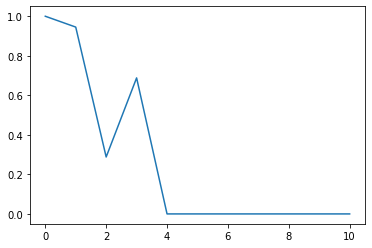

In [ ]:
plt.plot(pv_d)

end of correction

Epoch:0, cost= 0.018094
Epoch:1, cost= 0.017940
 Time's up, goodbye! 


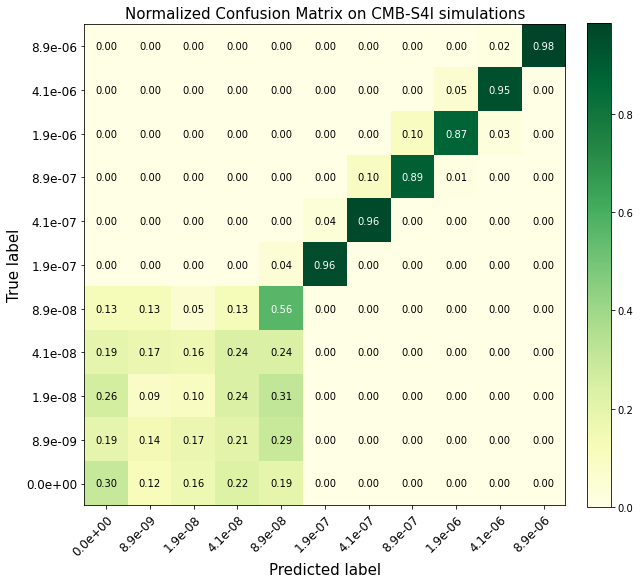

In [ ]:
conv.train(data_provider=odp,training_epochs=100000, 
            iterations=40, n_s=150,
            learning_rate = 0.000008 , verbose=1 , time_limit = 10)

Y_t  = [] 
pr_t = []

for _ in range(660):
    x,y = odp_test(1)
    pred = conv.predict(x)
    Y_t.append(np.argmax(y))
    pr_t.append(np.argmax(pred))

conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.YlGn,
             title='Normalized Confusion Matrix on CMB-S4I simulations', save=0 , name='cmb_s4i.jpg')       

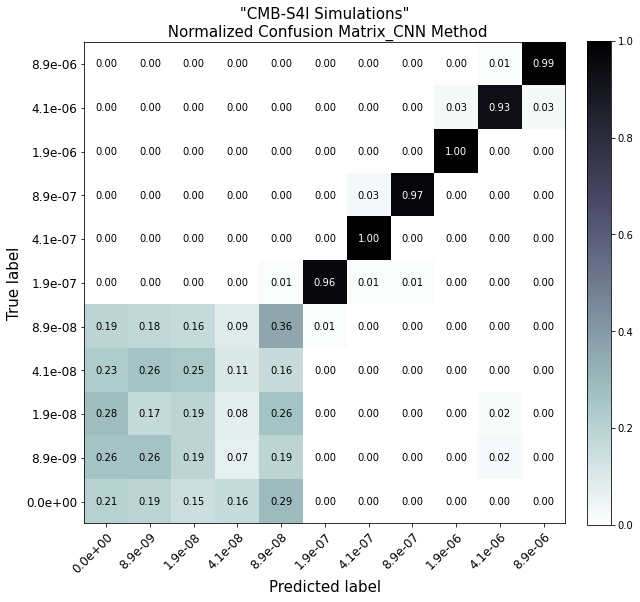

In [ ]:
# Y_t  = [] 
# pr_t = []

# for _ in range(1500):
#     x,y = odp_test(1)
#     pred = conv.predict(x)
#     Y_t.append(np.argmax(y))
#     pr_t.append(np.argmax(pred))

conf_plotter(Y_t , pr_t , labels , normalize=1, cmap = plt.cm.bone_r,
             title=' "CMB-S4I Simulations" \n Normalized Confusion Matrix_CNN Method', save=0 , name='Bilatnoise_s4i_conf.pdf')       

Normalized confusion matrix


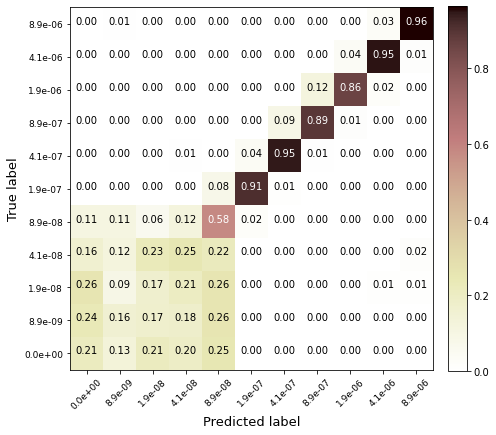

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          #title='Confusion matrix',
                          cmap=plt.cm.Purples):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.gca().invert_yaxis()

    #plt.title(title,fontsize = 15)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45 , fontsize=9)
    plt.yticks(tick_marks, classes , fontsize=9)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range((cm.shape[0])):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize = 13)
    plt.xlabel('Predicted label',fontsize = 13)
    plt.tight_layout()

labels = []
for gmu in gmus2:
    labels.append('{:3.1e}'.format(gmu))
labels

from sklearn.metrics import confusion_matrix


Y_t  = [] 
pr_t = []

for _ in range(1500):
    
    x, y = odp_test(1)
    pred = conv.predict(x)
    Y_t.append(np.argmax(y))
    pr_t.append(np.argmax(pred))

cnf_matrix = confusion_matrix(Y_t,pr_t)
np.set_printoptions(precision=2)

plt.figure(figsize=(7,7))
foo = plot_confusion_matrix(cnf_matrix, labels,normalize=True
                      ,cmap = plt.cm.pink_r)
plt.savefig('./cm_s4ii-2.png')

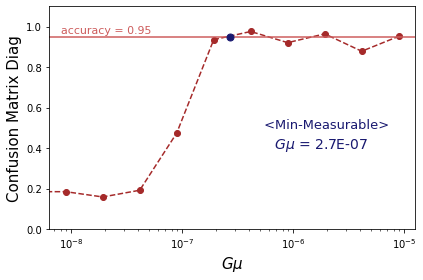

In [ ]:
plt.axes(xscale='log')
plt.xlabel('$G\mu$' ,   fontsize=15)
plt.ylabel('Confusion Matrix Diag' , fontsize=15)
plt.plot(gmus2 , np.diag(cm) , color='brown' , marker='o' , linestyle='--' )
# plt.plot(gmus2 , pv_m ,  color = 'darksalmon',linestyle='--')
plt.axhline(0.95 , color='indianred')
plt.text(0.000000008 , 0.97, 'accuracy = 0.95' , color='indianred' , fontsize=11 )
plt.plot(cm_mes , 0.95 , 'o' , markersize=7 , color='midnightblue')
plt.text(0.00000062 , 0.4 ,' $G\mu$ = {:.1E}'.format(cm_mes) , color='midnightblue'  , fontsize=14)
plt.text(0.0000005 , 0.5 ,' <Min-Measurable>'.format(cm_mes) , color='midnightblue'  , fontsize=13)

# plt.title('Noisy E2E: P-value $min_{mes}$')
plt.tight_layout()
plt.ylim(0,1.1)
plt.savefig('cm_m_s4ii.png')
# plt.savefig('TmoreMax_pv_mes.pdf')